In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [18]:
from replay.preprocessing.filters import MinCountFilter
from replay.splitters import TimeSplitter, LastNSplitter, ColdUserRandomSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

## Prepare data

In [ ]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/megamarket/interactions.parquet")

In [5]:
interactions.head()

,user_id,datetime,event,item_id,category_id,price,timestamp
0,1199174,2023-02-13 03:12:19.131,2,1861088,5395,-0.042062,1676257939131000000
1,3124963,2023-02-13 09:38:55.674,2,2084441,1531,0.079817,1676281135674000000
2,2106055,2023-02-13 08:26:05.004,2,2586689,9294,-0.038990,1676276765004000000
3,4169844,2023-02-13 16:55:08.470,2,2586689,9294,-0.038990,1676307308470000000
4,7472260,2023-02-13 03:30:13.093,2,2586689,9294,-0.038990,1676259013093000000


In [6]:
interactions.event.value_counts()

2    118342938
0     52961163
3     19879157
1      5460762
Name: event, dtype: int64

In [7]:
interactions = interactions[interactions.event == 2]

In [8]:
interactions['price'].describe()

count    1.183429e+08
mean     1.934640e-02
std      1.287710e+00
min     -4.296196e-02
25%     -3.973579e-02
50%     -3.029587e-02
75%      1.072477e-02
max      9.852566e+03
Name: price, dtype: float64

In [9]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 367038
Number of unique items: 3281750


In [11]:
pd.to_datetime(interactions['timestamp'], unit='ns').describe()

/tmp/ipykernel_1789660/1608285699.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(interactions['timestamp'], unit='ns').describe()


count                      118342938
unique                     114998264
top       2023-03-08 14:05:26.329000
freq                               8
first     2023-01-15 00:00:00.708000
last      2023-05-14 20:00:15.513000
Name: timestamp, dtype: object

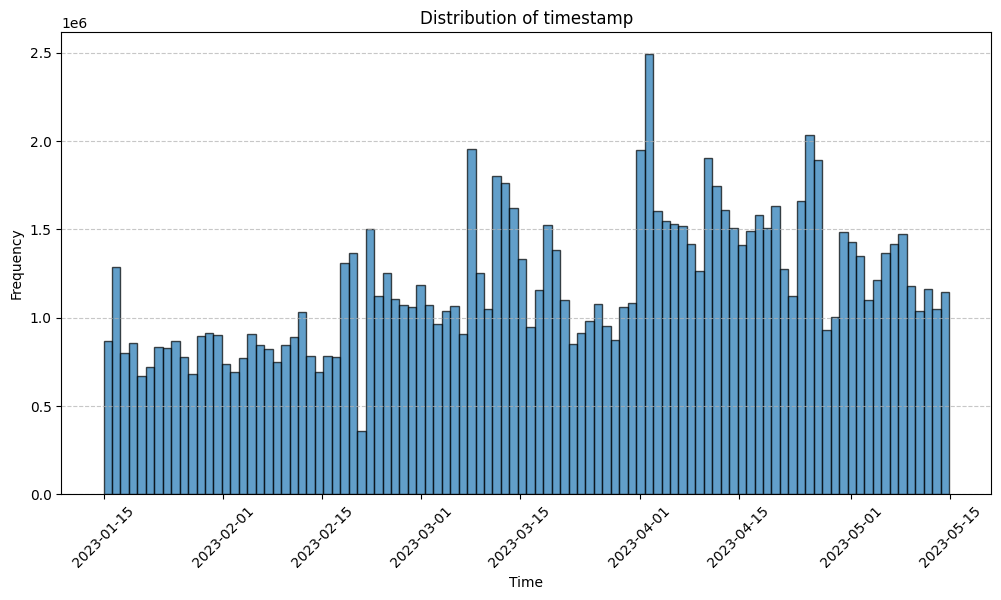

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ns', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 3


In [14]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='ns'))
print(pd.to_datetime(interactions.timestamp.max(), unit='ns'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(114846280, 7)
2023-01-15 00:00:00.708000
2023-05-14 20:00:15.513000
Interaction Density: 0.02%
Mean Sequence Length: 327.88


In [15]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 350267
Number of unique items: 1661327


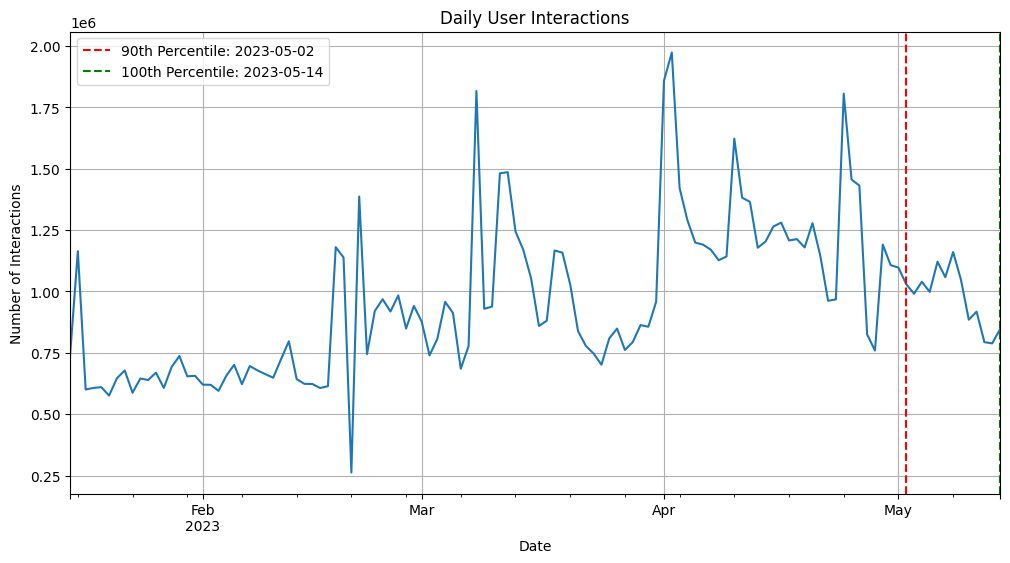

In [16]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ns')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    global_splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=False,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )
    val_splitter = ColdUserRandomSplitter(
        test_size=0.1,
        drop_cold_items=True,
        query_column="user_id",
        seed=42,
    )
    loo_splitter = LastNSplitter(
        N=1,
        drop_cold_users=True,
        drop_cold_items=False,
        divide_column="user_id",
        query_column="user_id",
        strategy="interactions",
    )

    train, raw_test = global_splitter.split(interactions)
    train_events, val = val_splitter.split(train)
    test_users = set(raw_test['user_id']) - set(val['user_id'])
    test_events, test_gt = loo_splitter.split(
        interactions[
            (interactions['user_id'].isin(test_users))
            & interactions['item_id'].isin(train_events['item_id'].unique())
        ]
    )
    validation_events, validation_gt = loo_splitter.split(val)
    test_gt = test_gt[test_gt['item_id'].isin(train_events['item_id'])]
    test_gt_correct = test_gt[test_gt['user_id'].isin(test_events['user_id'])]
    test_gt = test_gt[test_gt['user_id'].isin(train_events['user_id'])]
    print(
            f"Distribution of seq_len in validation:\n{validation_events.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    print(
        f"Distribution of seq_len in validation gt:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_events.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt correct:\n{test_gt_correct.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test gt:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    34221.000000
mean       294.506151
std        718.159881
min          1.000000
25%         25.000000
50%         84.000000
75%        267.000000
max      32485.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation gt:
count    34221.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    178160.000000
mean        503.216771
std         997.287638
min           1.000000
25%          64.000000
50%         190.000000
75%         512.000000
max       38547.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test gt correct:
count    178160.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: item_id, dtype: float64.
Distribution of seq_len in test gt:
count    171015.0
mean          1.0
std   